In [7]:
import json, requests, time
from sqlalchemy import create_engine
import pandas as pd

engine = create_engine('postgresql://postgres:argmax@pg:5432/postgres')


# Data
Every time a user opens a mobile app, an auction is going on behind the scenes. The highest bidder gets to advertise his ad to the user.
## Auctions Table

In [8]:
sql_query = 'SELECT * FROM auctions;'
with engine.connect() as db_con:
    df = pd.read_sql(sql_query, con=db_con)

df_auctions = df

## App Vectors table
We've gathered the first few sentences from the app store description and embedded it with a [model](https://huggingface.co/mixedbread-ai/mxbai-embed-large-v1)

In [9]:
sql_query = f'''
SELECT
    *
FROM app_vectors
'''
has_embedding = False
while not has_embedding:
    with engine.connect() as db_con:
        df = pd.read_sql(sql_query, con=db_con)
    has_embedding = (~df["embedding"].isna()).all()
    if not has_embedding:
        print("Waiting for embeddings...")
        time.sleep(15)

df
df_embeddings = df

We can use the `<=>` operator to run vector search within the database

In [10]:

vec = json.loads(df.embedding[0]) # get the first embedding
print ("Embedding size: {l}".format(l=len(vec)))

sql_query = f'''
SELECT
    "bundleId"
FROM app_vectors
ORDER BY embedding<=>'{json.dumps(vec)}'
'''
with engine.connect() as db_con:
    df = pd.read_sql(sql_query, con=db_con)

df

Embedding size: 1024


,bundleId
0,com.loop.match3d
1,com.loop.match3d
2,com.loop.match3d
3,com.loop.match3d
4,1502447854
...,...
67,1523081624
68,com.tintash.nailsalon
69,com.tintash.nailsalon
70,1523081624


## Hypothesis - 
apps with similar descriptions, would have a similar asking price in the auctions

In [22]:
!pip install scipy
!pip install seaborn
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 2.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 2.4 MB/s eta 0:00:00a 0:00:01


### Let's start with visualizations

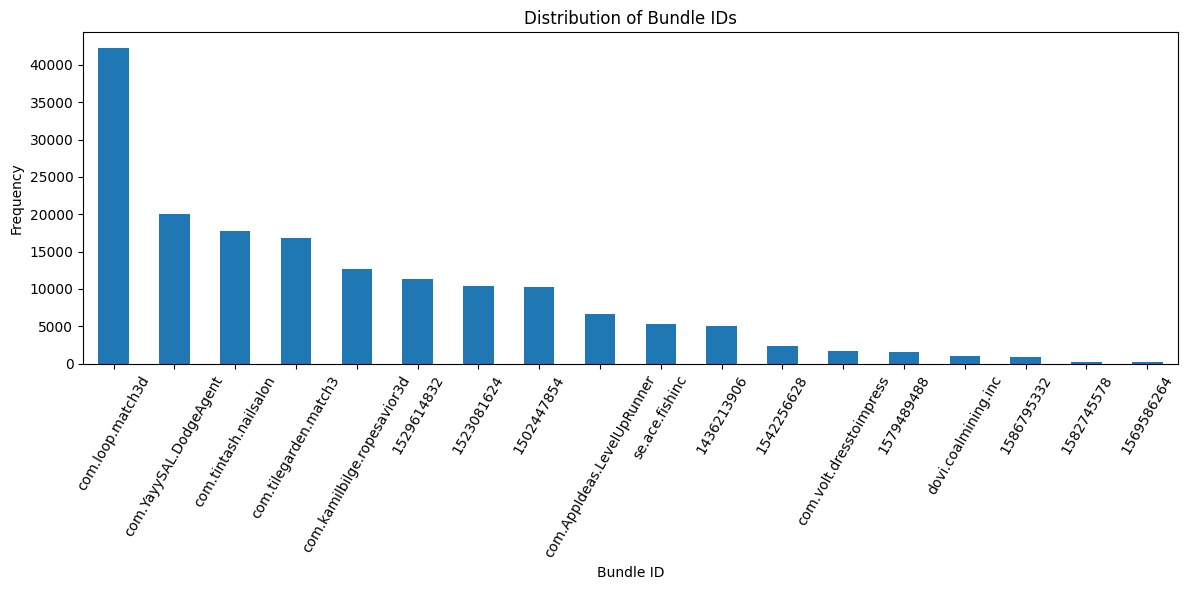

The bundle ID '1582745578' has the minimum count of 220.


In [23]:
import matplotlib.pyplot as plt

# Count occurrences of each bundle ID
bundle_id_counts = df_auctions['bundleId'].value_counts()

# Get bundle ID names (replace 'bundle_id_names' with your actual list or Series)
bundle_id_names = df_auctions['bundleId'].unique()

# Plotting
plt.figure(figsize=(12, 6))
bar_plot = bundle_id_counts.plot(kind='bar')
plt.title('Distribution of Bundle IDs')
plt.xlabel('Bundle ID')
plt.ylabel('Frequency')
plt.xticks(range(len(bundle_id_counts)), bundle_id_names, rotation=60)  # Set x-axis labels to bundle ID names
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()

# Print count of bundle ID with minimum count
min_bundle_id = bundle_id_counts.idxmin()
min_bundle_count = bundle_id_counts.min()
print(f"The bundle ID '{min_bundle_id}' has the minimum count of {min_bundle_count}.")


/tmp/ipykernel_146/844184888.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_embeddings_unique['embedding'] = df_embeddings_unique['embedding'].apply(ast.literal_eval)


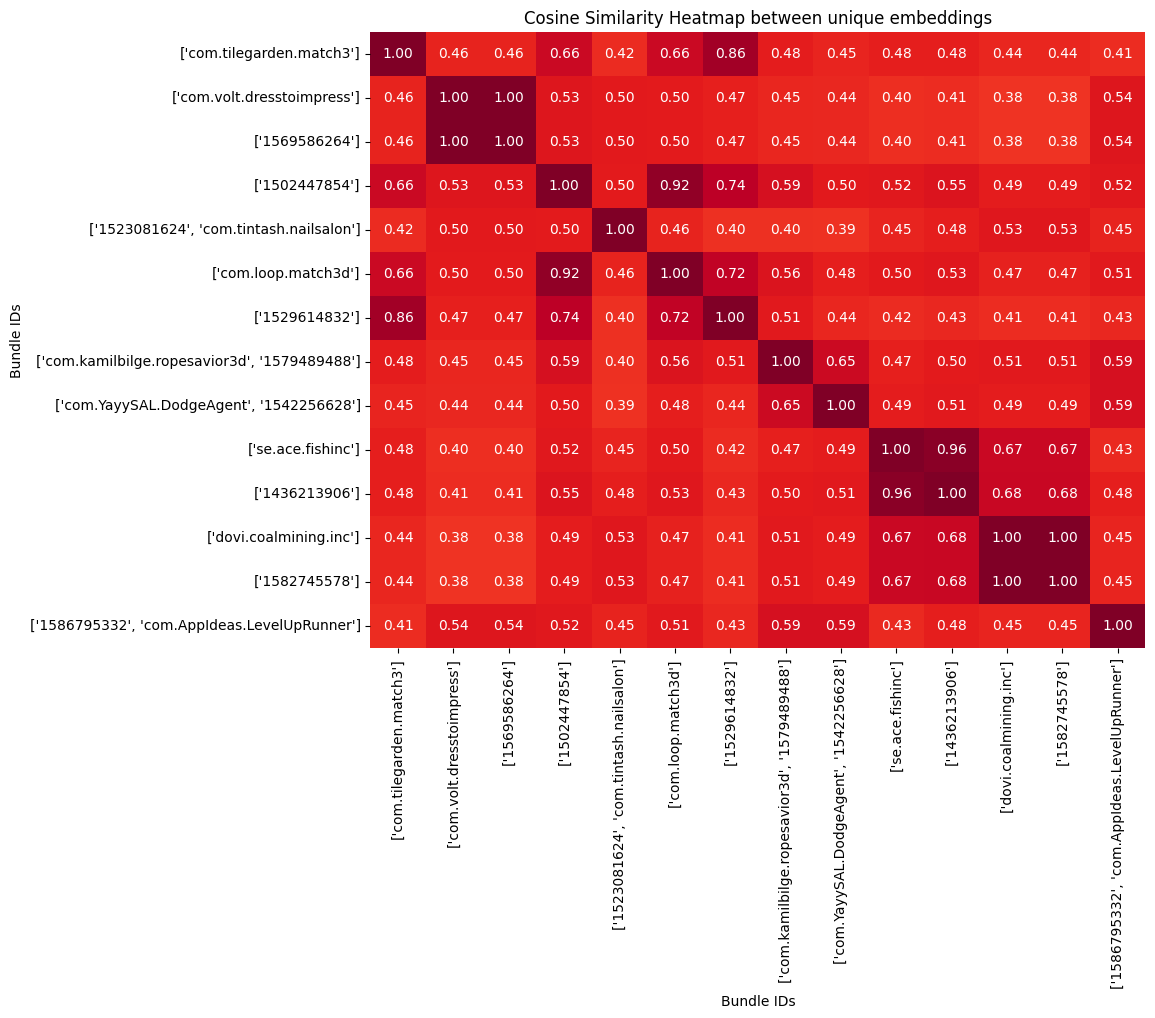

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances
import ast


# Drop duplicate rows based on 'embedding'
df_embeddings_unique = df_embeddings.drop_duplicates(subset=['embedding'])

# Convert string representations of lists to actual lists
df_embeddings_unique['embedding'] = df_embeddings_unique['embedding'].apply(ast.literal_eval)

# Group bundleIds by embedding
embedding_groups = df_embeddings.groupby(df_embeddings['embedding'].astype(str))['bundleId'].apply(list).to_dict()

# Extract embeddings and bundleIds
bundleIds = [list(set(bundleIds)) for bundleIds in embedding_groups.values()]
embedding_vectors = np.array(list(embedding_groups.keys()))

# Convert string representations of lists to actual lists in embedding_vectors
embedding_vectors = [ast.literal_eval(vec_str) for vec_str in embedding_vectors]

# Compute pairwise cosine similarity
similarity_matrix = 1 - pairwise_distances(embedding_vectors, metric='cosine')

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, cmap='YlOrRd', center=0, annot=True, fmt=".2f", cbar=False)

# Set the tick labels for x-axis and y-axis
plt.xticks(ticks=np.arange(0.5, len(bundleIds) + 0.5), labels=bundleIds, rotation=90, ha='center')
plt.yticks(ticks=np.arange(0.5, len(bundleIds) + 0.5), labels=bundleIds, rotation=0, va='center')

plt.title('Cosine Similarity Heatmap between unique embeddings')
plt.xlabel('Bundle IDs')
plt.ylabel('Bundle IDs')
plt.show()


### I will create groups of bundlid with similarity above a given threshold

In [25]:
def find_similar_apps(similarity_matrix, bundleIds, similarity_threshold=0.7):
    similar_apps = []
    min_similarity_list = []

    n = len(bundleIds)
    for i in range(n):
        similar_bundleIds = []
        min_similarity = 1.0
        if len(bundleIds[i]) == 2:
            similar_apps.append(bundleIds[i])
            min_similarity_list.append(min_similarity)

        for j in range(n):
            if similarity_matrix[i][j] > similarity_threshold and i != j :
                similar_bundleIds += bundleIds[i]
                similar_bundleIds += bundleIds[j]
                if similarity_matrix[i][j] < min_similarity:
                    min_similarity = similarity_matrix[i][j]

        min_similarity_list.append(min_similarity)
        similar_bundleIds = list(set(similar_bundleIds))
        similar_apps.append(similar_bundleIds)

    # Remove duplicate lists and empty lists
    unique_similar_apps = []
    unique_min_similarity_list = []
    for bundle_list,min_similarity in zip(similar_apps,min_similarity_list):
        if bundle_list and bundle_list not in unique_similar_apps:
            unique_similar_apps.append(bundle_list)
            unique_min_similarity_list.append(min_similarity)
    return unique_similar_apps,unique_min_similarity_list

# Example usage:
similar_groups, min_similarity_list = find_similar_apps(similarity_matrix, bundleIds, similarity_threshold = 0.7)
print(f"Min Similarity : {min_similarity_list})")
print(f"Similar Groups :")
similar_groups

Min Similarity : [0.85815394345895, 0.999999999999555, 0.7428159734879222, 1.0, 0.7190574889591241, 1.0, 1.0, 0.9563742123942047, 0.9999999999993971, 1.0])
Similar Groups :


[['1529614832', 'com.tilegarden.match3'],
 ['com.volt.dresstoimpress', '1569586264'],
 ['1529614832', 'com.loop.match3d', '1502447854'],
 ['1523081624', 'com.tintash.nailsalon'],
 ['com.tilegarden.match3', '1529614832', 'com.loop.match3d', '1502447854'],
 ['com.kamilbilge.ropesavior3d', '1579489488'],
 ['com.YayySAL.DodgeAgent', '1542256628'],
 ['se.ace.fishinc', '1436213906'],
 ['1582745578', 'dovi.coalmining.inc'],
 ['1586795332', 'com.AppIdeas.LevelUpRunner']]

### Explanation of the work process in this section-

In [33]:
import numpy as np
from scipy.stats import ttest_ind

def bootstrap_mean(data, num_samples=1000):
    means = []
    n = len(data)
    for _ in range(num_samples):
        sample = np.random.choice(data, size=n, replace=True)
        means.append(np.mean(sample))
    return means

def ttest_within_group(df_auctions, similar_groups,min_similarity_list, p_val_threshold=0.05):

    pass_test_groups = []
    for group,min_similarity in zip(similar_groups,min_similarity_list):

        p_values = []
        for bundleId in group:
            bundle_prices = df_auctions[df_auctions['bundleId'] == bundleId]['sentPrice']

            bundle_means = bootstrap_mean(bundle_prices)

            for other_bundleId in group:
                if bundleId != other_bundleId:
                    other_bundle_prices = df_auctions[df_auctions['bundleId'] == other_bundleId]['sentPrice']
                    other_bundle_means = df_auctions[df_auctions['bundleId'] == other_bundleId]['sentPrice']

                    t_statistic, p_value = ttest_ind(bundle_means, other_bundle_means, equal_var=False)
                    if not np.isnan(p_value):
                        p_values.append(p_value)
        # Calculate the average p-value between each pair of groups
        average_p_value = np.mean(p_values)

        if average_p_value <= p_val_threshold:
            pass_test_groups.append((group,average_p_value,min_similarity))

    return pass_test_groups

for similarity_threshold in [0.7,0.8,0.9,0.95]:
    similar_groups, min_similarity_list = find_similar_apps(similarity_matrix, bundleIds, similarity_threshold = similarity_threshold)
    pass_test_groups = ttest_within_group(df_auctions, similar_groups,min_similarity_list,  p_val_threshold=0.05)
    print(f"Threshold :{similarity_threshold} total number of groups {len(similar_groups)}, number of groups that perform ttest with p-value of less than 0.05: {len(pass_test_groups)}")
    print(f"Meaning {len(pass_test_groups)} does have significant difference within each group with confidence level of 0.05, and a min similarity of {min(pass_test_groups, key=lambda x: x[2])[2]}")
    print()


Threshold :0.7 total number of groups 10, number of groups that perform ttest with p-value of less than 0.05: 9
Meaning 9 does have significant difference within each group with confidence level of 0.05, and a min similarity of 0.7428159734879222

Threshold :0.8 total number of groups 10, number of groups that perform ttest with p-value of less than 0.05: 10
Meaning 10 does have significant difference within each group with confidence level of 0.05, and a min similarity of 0.85815394345895

Threshold :0.9 total number of groups 8, number of groups that perform ttest with p-value of less than 0.05: 8
Meaning 8 does have significant difference within each group with confidence level of 0.05, and a min similarity of 0.9226371026478282

Threshold :0.95 total number of groups 7, number of groups that perform ttest with p-value of less than 0.05: 7
Meaning 7 does have significant difference within each group with confidence level of 0.05, and a min similarity of 0.9563742123942047



### Results explanation first part-

## Are the previous results Consistency?

### Explanation of the work process in this section-

In [35]:
import numpy as np
from scipy.stats import ttest_ind

# Define a function to perform bootstrap resampling for 'sentPrice' means within each group for a specific column
def bootstrap_mean_within_group(data, column, min_samples=30, num_samples=50):
    group_means = []
    for group, group_data in data.groupby(column):
        # Check if the number of unique samples is greater than min_samples
        if len(group_data['sentPrice']) >= min_samples and len(group_data)>1:
            group_prices = group_data['sentPrice']
            means = []
            n = len(group_prices)
            for _ in range(num_samples):
                #print(len(group_prices))
                sample = np.random.choice(group_prices, size=n, replace=True)
                means.append(np.mean(sample))
            group_means.append((group, means))
    return group_means

# Define your DataFrame
# Let's say your DataFrame is called df

# Iterate over each column (except 'sentPrice')
for column in df_auctions.columns:
    if (column != 'sentPrice') & (len(df_auctions[column].unique())<10000):
        print(f"Column: {column}")
        # Perform bootstrap resampling and statistical tests within each group
        group_means = bootstrap_mean_within_group(df_auctions, column)
        p_values = []
        for group1_name, group1_means in group_means:
            means.append(np.mean(group1_means))
            for group2_name, group2_means in group_means:
                if group1_name != group2_name:
                    t_statistic, p_value = ttest_ind(group1_means, group2_means, equal_var=False)
                    # Check if p_value is not NaN
                    if not np.isnan(p_value):
                        p_values.append(p_value)

        # Calculate the average p-value between each pair of groups
        average_p_value = np.mean(p_values)
        print(f"Average p-value for each pair of groups: {average_p_value:.4f}, their is {len(df_auctions[column].unique())} groups")
        print()


Column: unitDisplayType
Average p-value for each pair of groups: 0.0000, their is 3 groups

Column: brandName
Average p-value for each pair of groups: 0.0148, their is 149 groups

Column: bundleId
Average p-value for each pair of groups: 0.0186, their is 18 groups

Column: countryCode
Average p-value for each pair of groups: 0.0163, their is 171 groups

Column: osAndVersion
Average p-value for each pair of groups: 0.0191, their is 97 groups

Column: bidFloorPrice
Average p-value for each pair of groups: 0.0000, their is 4 groups



### Results explanation second part-
We accepted that for each of the following columns in df_auctions - unitDisplayType, brandName, bundleId, countryCode, osAndVersion, bidFloorPrice, we rejected the H0 hypothesis, meaning we accepted that there is a difference between the different groups in the column and their sentprice,

their for the results are not consistent